# Figure 1

In [1]:
import numpy as np
from scipy.signal import detrend
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

datapath = '../Processed_data/Nino3_4_DJF/'
experiments = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'E3SM-1-0', 
          'EC-Earth3', 'EC-Earth3-Veg', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL',
           'HadGEM3-GC31-MM', 'UKESM1-0-LL', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2',
           'CESM2-WACCM', 'SAM0-UNICON', 'MCM-UA-1-0'] # , 'GFDL-ESM4'

historical_required_length = 165 - 1; # subtract 1 because of missing value first year
ssp_required_length = 86;
piControl_min_length = 496 - 1; # main member, that we use to compute errorbars.
piControl_min_length_other_members = 100; # used only for computing a mean value, so we don't require the same length

# create empty dataframe that will later be filled with values
cols = [('piControl', 'length'), ('piControl' ,'length of other members'), ('historical', 'members'), ('ssp126', 'members'), ('ssp245', 'members'), ('ssp370', 'members'), ('ssp585', 'members')]
df = pd.DataFrame(index = models, columns = cols)


In [2]:
def choose_member(datatable, exp, model):
    if exp == 'historical':
        required_length = historical_required_length; 
    elif exp in experiments[-4:]: # if future scenario
        required_length = ssp_required_length;
    elif exp == 'piControl':
        required_length = piControl_min_length;
    
    member_priority_list = ['r1i1p1f1', 'r1i1p1f2', 'r1i1p1f3', 'r2i1p1f2', 'r22i1p1f1', 'r2i1p1f1']
    chosen_member = None
    for member in member_priority_list:
        if member in datatable[exp]:
            data = np.array([np.float(i) for i in datatable[exp][member].values if i])
            #print(len(data))
            if len(data) >= required_length:
                chosen_member = member
                break
    if chosen_member == None:
        print('failed for', exp, model, ' - add more members to priority list')
    return chosen_member
    
# find ensemble members that exist for all experiments:
def common_member(datatable):
    model_exp = list(set([exp[0] for exp in data_table.columns]))
    exp_members = {}
    for exp in model_exp:
        exp_members[exp] = set([member for member in data_table[exp].columns])
    common_members = set.intersection(*exp_members.values())
    return common_members



## List common ensemble members across experiments:

In [3]:
for (k,model) in enumerate(models):
    file = model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
    print(model, common_member(data_table))

BCC-CSM2-MR {'r1i1p1f1'}
CanESM5 {'r1i1p2f1', 'r1i1p1f1'}
CNRM-CM6-1 {'r1i1p1f2'}
CNRM-ESM2-1 set()
E3SM-1-0 {'r1i1p1f1'}
EC-Earth3 set()
EC-Earth3-Veg {'r1i1p1f1'}
MIROC-ES2L {'r1i1p1f2'}
MIROC6 {'r1i1p1f1'}
HadGEM3-GC31-LL set()
HadGEM3-GC31-MM {'r1i1p1f1'}
UKESM1-0-LL {'r1i1p1f2'}
MRI-ESM2-0 {'r1i1p1f1'}
GISS-E2-1-G {'r2i1p1f1', 'r1i1p1f2', 'r102i1p1f1', 'r1i1p1f1', 'r101i1p1f1'}
CESM2 {'r1i1p1f1'}
CESM2-WACCM {'r1i1p1f1'}
SAM0-UNICON {'r1i1p1f1'}
MCM-UA-1-0 set()


In [4]:
# define x-coordiates and colors for each experiment
x = {}
colors = ['black', 'blue', 'purple', 'red', 'green', 'gray']
color_dict = {}
delta_x = 0.1
for ind,exp in enumerate(experiments):
    x[exp] = np.arange(len(models)) + 1 + delta_x*ind
    color_dict[exp] = colors[ind]

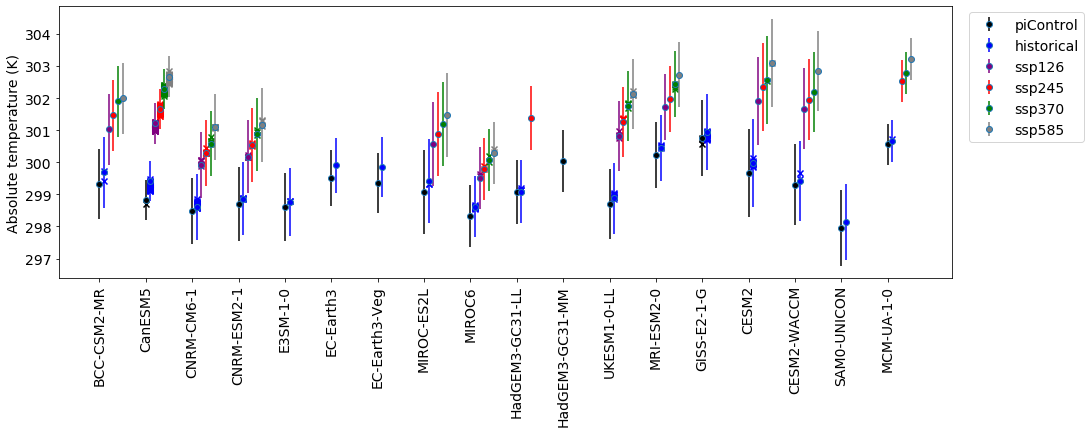

In [5]:
# create figure:
fig, ax = plt.subplots(figsize = [16,5])

for (k,model) in enumerate(models):
    file = model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
    members = {}
    for exp in experiments:
        members[exp] = 0
        if exp in data_table:
            plot_member = choose_member(data_table, exp, model)
            
            # plot other members first
            other_members = [member for member in data_table[exp] if member != plot_member]
            piControl_lengths = []
            for member in other_members:
                data_list = data_table[exp][member].values
                data = np.array([np.float(i) for i in data_list if i])
                if exp in experiments[-4:]: # if future scenario
                    if len(data) >= ssp_required_length:
                        data = data[:ssp_required_length] # stop in year 2100, and plot only data going to 2100
                        ax.scatter(x[exp][k], data.mean(), marker = 'x', color=color_dict[exp])
                        members[exp] += 1
                elif exp == 'historical':
                    if len(data) >= historical_required_length:
                        ax.scatter(x[exp][k], data.mean(), marker = 'x', color=color_dict[exp])
                        members[exp] += 1
                elif exp == 'piControl': 
                    if len(data) >= piControl_min_length_other_members:
                        ax.scatter(x[exp][k], data.mean(), marker = 'x', color=color_dict[exp])
                        members[exp] += 1
                        piControl_lengths.append(str(len(data) + 1))
                        
            # plot chosen member with error bars from piControl std
            data_list = data_table[exp][plot_member].values
            # remove empty strings and convert remaining strings to float:
            data = np.array([np.float(i) for i in data_list if i])
            if exp in experiments[-4:]: # if future scenario
                data = data[:ssp_required_length] # stop in year 2100
            if exp == 'piControl':
                control_data = data
                df.loc[model][('piControl', 'length')] = len(control_data) + 1 # to give original length
                df.loc[model][('piControl', 'length of other members')] = ",".join(piControl_lengths)
            if k == 0:
                # define also labels for legend
                ax.errorbar(x[exp][k], data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp], label = exp)
                members[exp] += 1
            else:
                ax.errorbar(x[exp][k], data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp])
                members[exp] += 1
        # save number of members in dataframe
        if exp in experiments[1:]:
            df.loc[model][(exp, 'members')] = members[exp]
    
ax.tick_params(axis='both',labelsize=14)    
ax.set_ylabel('Absolute temperature (K)', fontsize = 14)
plt.xticks(x['piControl'], models, rotation=90);
ax.legend(loc=(1.02,0.5), fontsize = 14);

#plt.savefig('../Figures/Figure1_absolute.png', format='png', dpi=300, bbox_inches="tight")

BCC-CSM2-MR r1i1p1f1 piControl
BCC-CSM2-MR r1i1p1f1 historical
BCC-CSM2-MR r1i1p1f1 ssp126
BCC-CSM2-MR r1i1p1f1 ssp245
BCC-CSM2-MR r1i1p1f1 ssp370
BCC-CSM2-MR r1i1p1f1 ssp585
CanESM5 r1i1p1f1 piControl
CanESM5 r1i1p1f1 historical
CanESM5 r1i1p1f1 ssp126
CanESM5 r1i1p1f1 ssp245
CanESM5 r1i1p1f1 ssp370
CanESM5 r1i1p1f1 ssp585
CNRM-CM6-1 r1i1p1f2 piControl
CNRM-CM6-1 r1i1p1f2 historical
CNRM-CM6-1 r1i1p1f2 ssp126
CNRM-CM6-1 r1i1p1f2 ssp245
CNRM-CM6-1 r1i1p1f2 ssp370
CNRM-CM6-1 r1i1p1f2 ssp585
CNRM-ESM2-1 r1i1p1f2 piControl
CNRM-ESM2-1 r1i1p1f2 historical
CNRM-ESM2-1 r1i1p1f2 ssp126
CNRM-ESM2-1 r1i1p1f2 ssp245
CNRM-ESM2-1 r2i1p1f2 ssp370
CNRM-ESM2-1 r2i1p1f2 ssp585
E3SM-1-0 r1i1p1f1 piControl
E3SM-1-0 r2i1p1f1 historical
EC-Earth3 r1i1p1f1 piControl
EC-Earth3 r22i1p1f1 historical
EC-Earth3-Veg r1i1p1f1 piControl
EC-Earth3-Veg r1i1p1f1 historical
MIROC-ES2L r1i1p1f2 piControl
MIROC-ES2L r1i1p1f2 historical
MIROC-ES2L r1i1p1f2 ssp126
MIROC-ES2L r1i1p1f2 ssp245
MIROC-ES2L r1i1p1f2 ssp370
MIRO

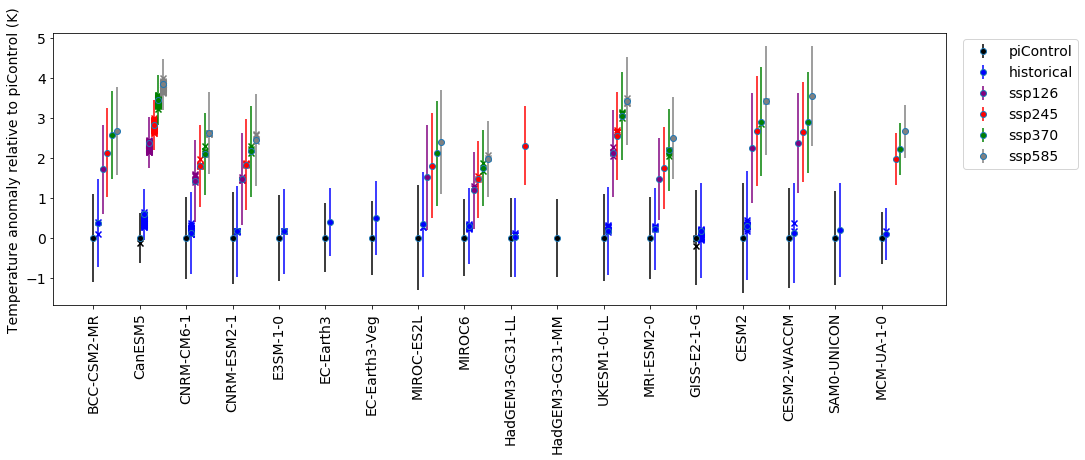

In [6]:
# create figure:
fig, ax = plt.subplots(figsize = [16,5])

for (k,model) in enumerate(models):
    file = model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
    
    for exp in experiments:
        if exp in data_table:
            plot_member = choose_member(data_table, exp, model)
                
            print(model,plot_member, exp)
            data_list = data_table[exp][plot_member].values
            # remove empty strings and convert remaining strings to float:
            data = np.array([np.float(i) for i in data_list if i])
            
            if exp in experiments[-4:]: # if future scenario
                data = data[:ssp_required_length] # stop in year 2100

            if exp == 'piControl':
                control_data = data
            if k == 0:
                # define labels for legend
                ax.errorbar(x[exp][k], data.mean() - control_data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp], label = exp)
            else:
                ax.errorbar(x[exp][k], data.mean() - control_data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp])
                        
            # plot other members
            other_members = [member for member in data_table[exp] if member != plot_member]
            for member in other_members:
                data_list = data_table[exp][member].values
                data = np.array([np.float(i) for i in data_list if i])
                if exp in experiments[-4:]: # if future scenario
                    if len(data) >= ssp_required_length:
                        data = data[:ssp_required_length] # stop in year 2100, and plot only data going to 2100
                        ax.scatter(x[exp][k], data.mean() - control_data.mean(), marker = 'x', color=color_dict[exp])
                elif exp == 'historical':
                    if len(data) >= historical_required_length:
                        ax.scatter(x[exp][k], data.mean() - control_data.mean(), marker = 'x', color=color_dict[exp])
                elif exp == 'piControl':
                    if len(data) >= piControl_min_length_other_members:
                        ax.scatter(x[exp][k], data.mean() - control_data.mean(), marker = 'x', color=color_dict[exp])
ax.tick_params(axis='both',labelsize=14)
ax.set_ylabel('Temperature anomaly relative to piControl (K)', fontsize = 14)
plt.xticks(x['piControl'], models, rotation=90);
ax.legend(loc=(1.02,0.5), fontsize = 14);

#plt.savefig('../Figures/Figure1_anomalies.png', format='png', dpi=300, bbox_inches="tight")

## Table of what data are used in this figure:

In [7]:
df

,"(piControl, length)","(piControl, length of other members)","(historical, members)","(ssp126, members)","(ssp245, members)","(ssp370, members)","(ssp585, members)"
BCC-CSM2-MR,600,,3,1,1,1,1
CanESM5,1000,451,50,50,50,50,50
CNRM-CM6-1,500,,18,6,6,6,6
CNRM-ESM2-1,500,,5,5,5,4,4
E3SM-1-0,500,,3,0,0,0,0
EC-Earth3,501,,1,0,0,0,0
EC-Earth3-Veg,500,,1,0,0,0,0
MIROC-ES2L,500,,3,1,1,1,1
MIROC6,800,,10,3,3,3,3
HadGEM3-GC31-LL,500,,4,0,1,0,0


## Convert dataframe to latex format:

In [8]:
# drop column of other piControl lengths, and put it in manually in parentheses later
new_cols = cols[:]
new_cols.remove(('piControl' ,'length of other members'))
new_cols

[('piControl', 'length'),
 ('historical', 'members'),
 ('ssp126', 'members'),
 ('ssp245', 'members'),
 ('ssp370', 'members'),
 ('ssp585', 'members')]

In [9]:
df.loc[:,new_cols].to_latex()
# to be copied into a latex document

'\\begin{tabular}{lllllll}\n\\toprule\n{} & (piControl, length) & (historical, members) & (ssp126, members) & (ssp245, members) & (ssp370, members) & (ssp585, members) \\\\\n\\midrule\nBCC-CSM2-MR     &                 600 &                     3 &                 1 &                 1 &                 1 &                 1 \\\\\nCanESM5         &                1000 &                    50 &                50 &                50 &                50 &                50 \\\\\nCNRM-CM6-1      &                 500 &                    18 &                 6 &                 6 &                 6 &                 6 \\\\\nCNRM-ESM2-1     &                 500 &                     5 &                 5 &                 5 &                 4 &                 4 \\\\\nE3SM-1-0        &                 500 &                     3 &                 0 &                 0 &                 0 &                 0 \\\\\nEC-Earth3       &                 501 &                     1 &            